# **PRÁCTICA 3: GANs - Parte 1: GANs simples**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos


## **Ejercicio 2: Modifica el código para que use el dataset cifar10 en lugar del mnist** 

## Importamos librerías 

In [ ]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.datasets.cifar10 import load_data
import tensorflow as tf

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY

## Cargamos conjunto de datos

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

In [ ]:
print("X_train.shape =", x_train.shape, "Y_train.shape =", y_train.shape)
print("X_test.shape =", x_test.shape, "Y_test.shape =", y_test.shape)

X_train.shape = (50000, 32, 32, 3) Y_train.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3) Y_test.shape = (10000, 1)


## Visualizamos cifar10

In [ ]:
num_clases = 10
clases = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

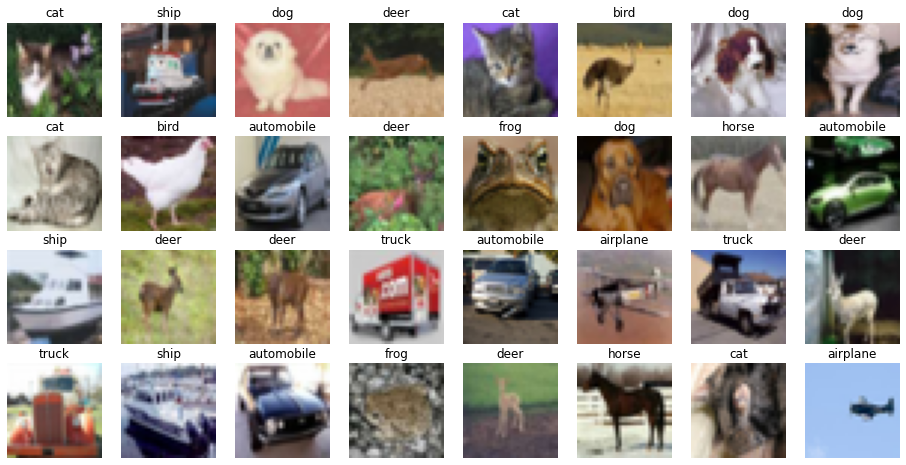

In [ ]:
cols = 8 # número de columnas
rows = 4 # número de filas

fig = plt.figure(figsize=(2 * cols, 2 * rows))
for col in range(cols):
    for row in range(rows):
        random_index = np.random.randint(0, len(y_train)) 
        ax = fig.add_subplot(rows, cols, col * rows + row + 1) 
        ax.grid(b=False) 
        ax.axis("off") 
        ax.imshow(x_train[random_index, :]) 
        ax.set_title(clases[y_train[random_index][0]]) 
plt.show() 

## Pre-procesamiento del set de datos

In [ ]:
X_train = x_train / 255.0

## Diseñamos modelo

In [ ]:
width= x_train.shape[1]
height= x_train.shape[2]
channels= x_train.shape[3]

in_shape = X_train.shape
in_shape = in_shape[1:]
OPTIMZADOR_ADAM = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_gen = Sequential()

model_gen.add(Dense(256, input_shape=(100,))) # vector de 100 de ruido
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(512))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(1024))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(np.prod(in_shape), activation='tanh')) 
model_gen.add(Reshape(in_shape)) 

model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_30 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_62 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_31 (Bat  (None, 512)              2048      
 chNormalization)                                    

In [ ]:
model_Disc = Sequential()
model_Disc.add(Flatten(input_shape=in_shape))
model_Disc.add(Dense(128, input_shape = (np.prod(in_shape)+1,)))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(64))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(1, activation='sigmoid'))
model_Disc.summary()

model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_65 (Dense)            (None, 128)               393344    
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_66 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_67 (Dense)            (None, 1)                 65        
                                                                 
Total params: 401,665
Trainable params: 401,665
Non-t

In [ ]:
model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

model_gan.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 32, 32, 3)         3838720   
                                                                 
 sequential_24 (Sequential)  (None, 1)                 401665    
                                                                 
Total params: 4,240,385
Trainable params: 4,236,801
Non-trainable params: 3,584
_________________________________________________________________


### Entrenamiento

In [ ]:
# Parámetros del entrenamiento
epochs = 1000 
batch = 10

# Bucle entrenamiento
DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

for cnt in range(epochs):

    ## Entrenamos discriminador
        # Imágenes reales
    random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
    legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape((np.int64(batch/2),) + in_shape)

        # Imágenes sintéticas
    gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
    syntetic_images = model_gen.predict(gen_noise)
        
        # Combinamos imágenes reales y sintéticas
    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
        # Entrenamos discriminador
    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)

    ## Entrenamos generador
        # Imágenes sintéticas
    noise = np.random.normal(0, 1, (batch, 100))
    y_mislabled = np.ones((batch, 1))
        # Entremaos generador
    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    ## Evolución entrenamiento
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss 

epoch: 0, [Discriminator :: d_loss: 0.855696], [ Generator :: loss: 0.289732]
epoch: 1, [Discriminator :: d_loss: 0.814349], [ Generator :: loss: 0.309881]
epoch: 2, [Discriminator :: d_loss: 0.799376], [ Generator :: loss: 0.315365]
epoch: 3, [Discriminator :: d_loss: 0.838249], [ Generator :: loss: 0.309848]
epoch: 4, [Discriminator :: d_loss: 0.810450], [ Generator :: loss: 0.297844]
epoch: 5, [Discriminator :: d_loss: 0.862804], [ Generator :: loss: 0.295547]
epoch: 6, [Discriminator :: d_loss: 0.812291], [ Generator :: loss: 0.302651]
epoch: 7, [Discriminator :: d_loss: 1.004490], [ Generator :: loss: 0.297043]
epoch: 8, [Discriminator :: d_loss: 0.840197], [ Generator :: loss: 0.316758]
epoch: 9, [Discriminator :: d_loss: 0.825647], [ Generator :: loss: 0.365146]
epoch: 10, [Discriminator :: d_loss: 0.802001], [ Generator :: loss: 0.392013]
epoch: 11, [Discriminator :: d_loss: 0.779407], [ Generator :: loss: 0.331655]
epoch: 12, [Discriminator :: d_loss: 0.868347], [ Generator ::

Curvas de aprendizaje

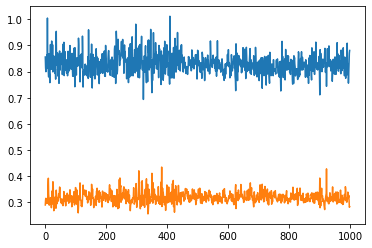

In [ ]:
% matplotlib inline 
plt.figure
plt.plot(DD_loss)
plt.plot(GG_loss)

# Generar datos

In [ ]:
# Generamos imagen sintética
numero = np.int64(20)
gen_noise = np.random.normal(0, 1, (numero, 100))
syntetic_images = model_gen.predict(gen_noise)

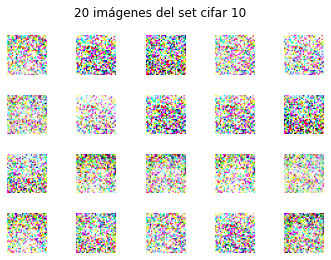

In [ ]:
for i in range(numero):
  plt.subplot(4,5,i+1)
  plt.imshow((syntetic_images[i] * 255).astype(np.uint8))
  plt.subplots_adjust(hspace=0.5)
  plt.suptitle('20 imágenes del set cifar 10')
  plt.axis('off')